In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def draw_image(popout=False):
    image = Image.new(mode="RGB", color=(0, 0, 0), size=(image_size, image_size))
    for i in range(m):
        for j in range(m):
            color = (0, 0, 0) if matrix[i, j] else (255, 255, 255)
            for k in range(i*d, i*d + d):
                for l in range(j*d, j*d + d):
                    image.putpixel((k, l), color)
    display(image)
    if popout:
        image.show()


def plot_energy(energy):
    plt.plot([i for i in range(len(energy))], energy)
    plt.title("Energy levels")
    plt.show()


def plot_temperature(temperature):
    plt.plot([i for i in range(len(temperature))], temperature)
    plt.title("Temperature function")
    plt.show()

In [3]:
def prepare_image():
    for i in range(m):
        for j in range(m):
            matrix[i, j] = 1 if np.random.rand() < density else 0

In [87]:
def cell_energy1(x, y):
    energy = 0
    energy += matrix[x, y]^matrix[x, y+1]
    energy += matrix[x, y]^matrix[x+1, y]
    energy += matrix[x, y]^matrix[x, y-1]
    energy += matrix[x, y]^matrix[x-1, y]
    return energy

def calc_diff1(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)


def cell_energy2(x, y):
    energy = 0
    energy += matrix[x, y] * matrix[x, y+1]
    energy += matrix[x, y] * matrix[x+1, y]
    energy += matrix[x, y] * matrix[x, y-1]
    energy += matrix[x, y] * matrix[x-1, y]
    return energy


def calc_diff2(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)


def cell_energy3(x, y):
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            energy += abs(matrix[x, y] - matrix[x+i, y+j])
    return energy


def calc_diff3(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)

def cell_energy4(x, y):
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            energy += matrix[x, y]*matrix[x+i, y+j]
    return energy - matrix[x, y]


def calc_diff4(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)


def cell_energy5(x, y):
    energy = 0
    t = [-1, 1]
    for i in t:
        for j in t:
            energy += matrix[x, y]*matrix[x+i, y+j]
    return energy


def calc_diff5(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)

def cell_energy6(x, y):
    energy = 0
    t = [-1, 1]
    for i in t:
        for j in t:
            energy += abs(matrix[x, y] - matrix[x+i, y+j])
    return energy


def calc_diff6(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)

def cell_energy7(x, y):
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            energy += matrix[x, y] | matrix[x+i, y+j]
    return energy


def calc_diff7(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)


def cell_energy8(x, y):
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i != 0 or j != 0:
                energy += (matrix[x, y]*matrix[x+i, y+j]) << (abs(i) + abs(j) - 1)
    return energy


def calc_diff8(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)

def cell_energy9(x, y):
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i != 0 or j != 0:
                energy += ((matrix[x, y]*matrix[x+i, y+j]) << 1) >> (abs(i) + abs(j) - 1)
    return energy


def calc_diff9(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)

def cell_energy10(x, y):
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i != 0 or j != 0:
                energy += ((matrix[x, y] ^ matrix[x+i, y+j]) << 1) >> (abs(i) + abs(j) - 1)
    return energy


def calc_diff10(changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(p1[0], p1[1]) + cell_energy(p2[0], p2[1])
    return 2*(after - before)


def neighbor1():
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = 0, 0
    if np.random.randint(0, 2):
        x_d = 1
    else:
        y_d = 1
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None


def neighbor2():
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = 0, 0
    if np.random.randint(0, 2):
        if np.random.randint(0, 2):
            x_d = 1
        else:
            x_d = -1
    else:
        if np.random.randint(0, 2):
            y_d = 1
        else:
            y_d = -1
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None

def neighbor3():
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = np.random.randint(-1, 2), np.random.randint(-1, 2)
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None

def neighbor4():
    t = [-1, 1]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = t[np.random.randint(-1, 2)], t[np.random.randint(-1, 2)]
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None


def revert(changes):
    s1, s2 = changes
    matrix[s1[0], s1[1]], matrix[s2[0], s2[1]] = matrix[s2[0], s2[1]] , matrix[s1[0], s1[1]]

In [88]:
def calculate_initial_energy(single_cell_energy):
    energy = 0
    for i in range(1, m - 1):
        for j in range(1, m - 1):
            energy += single_cell_energy(i, j)
    return energy

In [89]:
def annealing(alpha=0.999, T0=100, steps=50000, no_of_iter=1000, swap=neighbor1, cell_energy=cell_energy1, calc_diff=calc_diff1):
    T = T0
    temperature = [T]
    cur_energy = calculate_initial_energy(cell_energy)
    energy_states = [cur_energy]

    for i in range(steps):
        for j in range(no_of_iter):
            changes = swap()
            if changes is None:
                continue
            delta = calc_diff(changes, cell_energy)
            if delta < 0:
                cur_energy += delta
            else:
                if np.exp((-delta) / T) > np.random.uniform(0, 1):
                    cur_energy += delta
                else:
                    revert(changes)
            energy_states.append(cur_energy)
        if i % 10000 == 0:
            print(i)
        T *= alpha
        temperature.append(T)


    draw_image(popout=True)
    plot_energy(energy_states)
    plot_temperature(temperature)

In [90]:
def count_pixels():
    count1, count2 = 0, 0
    for i in range(m):
        for j in range(m):
            if matrix[i, j] == 0:
                count1 += 1
            elif matrix[i, j] == 1:
                count2 += 1
    return count1, count2

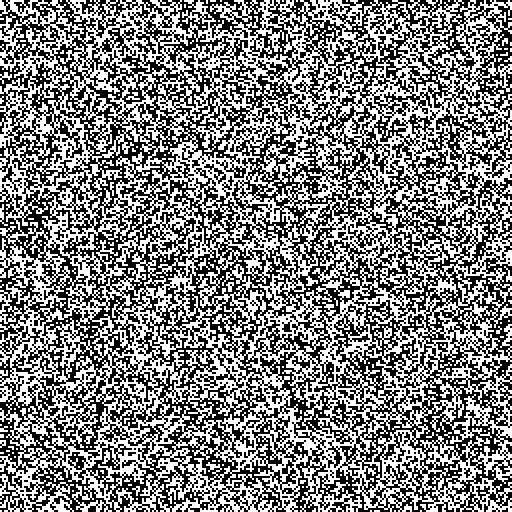

32739 32797


In [94]:
m = 256
image_size = 512
density = 0.5
d = image_size // m
matrix = np.zeros((m, m), dtype=int)
prepare_image()
draw_image(popout=True)

white1, black1 = count_pixels()
print(white1, black1)

0
10000
20000
30000
40000


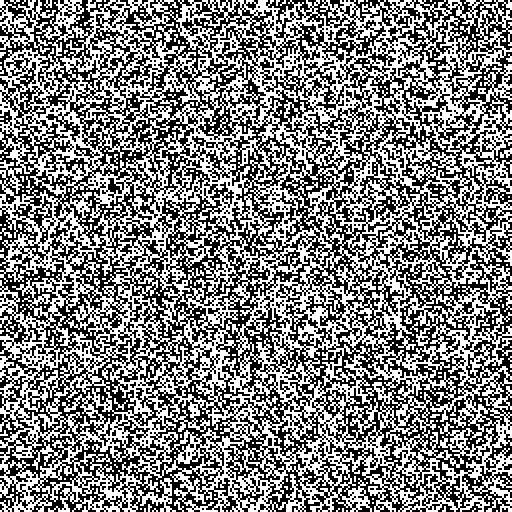

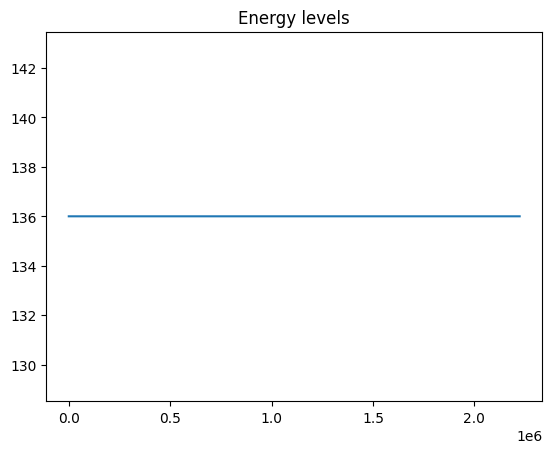

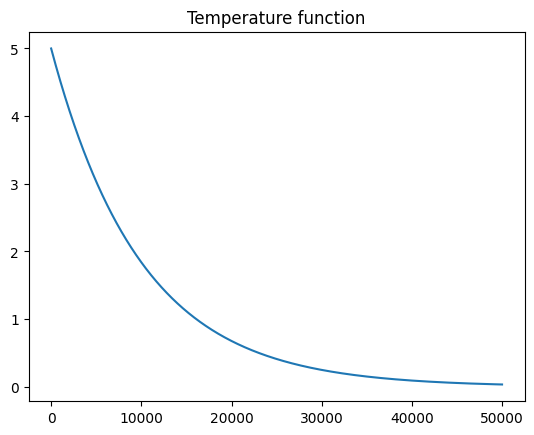

32739 32797


In [95]:
annealing(alpha=0.9999, steps = 50000, no_of_iter=100, T0=5, swap=neighbor3, calc_diff=calc_diff10, cell_energy=cell_energy10)
white2, black2 = count_pixels()
print(white2, black2)